# Batch Coactivity Analysis

## Notebook for preprocessing and analyzing coactivity spine data

In [1]:
import os
import numpy as np
from Lab_Analyses.Spine_Analysis.preprocess_spine_data import organize_dual_spine_data
from Lab_Analyses.Spine_Analysis.grouped_coactivity_analysis import grouped_coactivity_analysis
from Lab_Analyses.Spine_Analysis.coactivity_plasticity_analysis import Coactivity_Plasticity
from Lab_Analyses.Utilities.save_load_pickle import load_pickle

### Datasets
Specify mice which mice to be processed and analyzed

In [ ]:
# Mouse ids
id_1 = "JW082"
id_2 = "JW083"
id_3 = "JW090"
id_4 = "JW092"
id_5 = "JW126"
id_6 = "JW129"
id_7 = "JW130"

mouse_list = [id_1, id_2, id_3, id_4, id_5, id_6, id_7]
#mouse_list = [id_4, id_6]

### Preprocessing
Preprocess spine datasets

In [ ]:
# Do you want to reprocess the data
reprocess = False
channels = {"GluSnFr": "GreenCh", "Calcium": "RedCh"}
fov_type = "apical"

# Process data
if reprocess:
    for mouse in mouse_list:
        organize_dual_spine_data(mouse, channels, fov_type=fov_type, redetection=True, save=True, structural=True)

### Grouped Coactivity Analysis
Perform coactivity analysis across all mice and FOVs for a given set of imaging sessions

In [ ]:
# Set up parameters
## Save path
group_path = r'C:\Users\Jake\Desktop\Analyzed_data\grouped'
experiment_dir = "Dual_Spine_Imaging"
coactivity_dir = "Coactivity_Data"
coactivity_path = os.path.join(group_path, experiment_dir, coactivity_dir)

## Analysis parameters
reanalyze = True
save = True
days = ["Early", "Middle", "Late"]
#days = ["Middle"]
followup = True
zscore = False
volume_norm = True
fov_type = "apical"

coactivity_data = {}
for day in days:
    print(f"-{day}")
    coactivity = grouped_coactivity_analysis(
        mouse_list,
        day,
        followup=followup,
        fov_type=fov_type,
        activity_window=(-2,4),
        zscore=zscore,
        volume_norm=volume_norm,
        save=save,
        save_path=coactivity_path,
    )

    coactivity_data[day] = coactivity

In [2]:
group_path = r'C:\Users\Jake\Desktop\Analyzed_data\grouped'
experiment_dir = "Dual_Spine_Imaging"
coactivity_dir = "Coactivity_Data"
coactivity_path = os.path.join(group_path, experiment_dir, coactivity_dir)

load_coactivity = True
if load_coactivity:
    names = ["Early_dFoF_norm_spine_coactivity_data", "Middle_dFoF_norm_spine_coactivity_data", "Late_dFoF_norm_spine_coactivity_data"]
    data = load_pickle(names, coactivity_path)
    days = ["Early", "Middle", "Late"]
    coactivity_data = dict(zip(days, data))

### Coactivity Plasticity Analysis
Perform analysis to relate subsequent plasticity to coactivity 

In [3]:
## Save path
group_path = r'C:\Users\Jake\Desktop\Analyzed_data\grouped'
experiment_dir = "Dual_Spine_Imaging"
plasticity_dir = "Coactivity_Plasticity"
plasticity_path = os.path.join(group_path, experiment_dir, plasticity_dir)

In [4]:

## Analysis parameters
threshold = 0.5
exclude = "Shaft Spine"
save = True

plasticity_data = {}
for key, value in coactivity_data.items():
    plasticity = Coactivity_Plasticity(
        value, threshold, exclude, vol_norm=False, save=save, save_path=plasticity_path
    )
    plasticity_data[key] = plasticity

### Visualize Coactivity Plasticity Data
Plot selected data and variables from individual datasets.
Use data generated above of load in a dataset

In [5]:
# Select data to plot
load_data = False
initial_path = r"C:\Users\Jake\Desktop\Figures\grouped_data"
figure_path = os.path.join(initial_path, experiment_dir, plasticity_dir, "Early")
if not os.path.isdir(figure_path):
    os.makedirs(figure_path)
if load_data:
    load_name = "Early_dFoF_norm_0.5_coactivity_plasticity_data"
    plot_data = load_pickle([load_name], plasticity_path)[0]
else:
    plot_data = plasticity_data["Early"]


In [6]:
# Print out variable names
for key in plot_data.__dict__.keys():
    print(key)

day
threshold
exclude
vol_norm
parameters
save
save_path
group_dict
relative_volumes
enlarged_spines
shrunken_spines
stable_spines
mouse_id
FOV
spine_flags
followup_flags
spine_volumes
spine_volumes_um
followup_volumes
followup_volumes_um
movement_spines
nonmovement_spines
rwd_movement_spines
rwd_nonmovement_spines
movement_dendrites
nonmovement_dendrites
rwd_movement_dendrites
rwd_nonmovement_dendrites
spine_activity_rate
dend_activity_rate
distance_activity_rate
distance_relative_activity_rate
distance_coactivity_rate
distance_coactivity_rate_norm
MRS_distance_coactivity_rate
MRS_distance_coactivity_rate_norm
nMRS_distance_coactivity_rate
nMRS_distance_coactivity_rate_norm
movement_distance_coactivity_rate
movement_distance_coactivity_rate_norm
nonmovement_distance_coactivity_rate
nonmovement_distance_coactivity_rate_norm
avg_local_coactivity_rate
avg_local_coactivity_rate_norm
avg_MRS_local_coactivity_rate
avg_MRS_local_coactivity_rate_norm
avg_nMRS_local_coactivity_rate
avg_nMRS_lo

In [7]:
print(len(plot_data.avg_local_coactivity_rate))

243


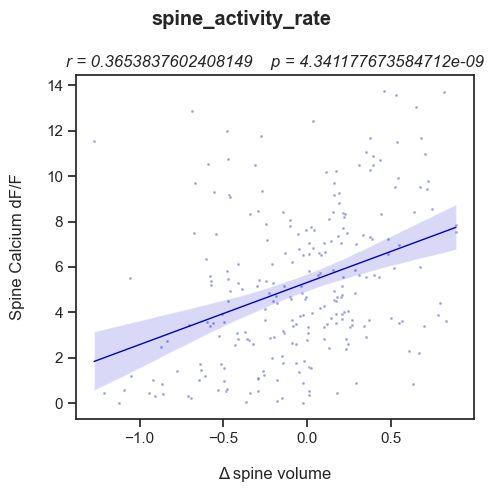

In [8]:
# Correlation Plots
plot_data.plot_volume_correlation(
    variable_name="spine_activity_rate",
    volume_type="relative_volume",
    CI=95,
    ytitle="Spine Calcium dF/F",
    xlim=None,
    ylim=None,
    face_color="mediumblue",
    edge_color="white",
    edge_width=1,
    s_alpha=0.4,
    line_color="mediumblue",
    line_width=1,
    log_trans=True,
    save=False,
    save_path=figure_path
)

F statistic: 27.994678141071475     p_value: 8.337443048239763e-07
╒════════════════════════════════════╤═══════════════════╕
│ comparison                         │   adjusted p-vals │
╞════════════════════════════════════╪═══════════════════╡
│ enlarged_spines vs shrunken_spines │       9.80097e-07 │
├────────────────────────────────────┼───────────────────┤
│ enlarged_spines vs stable_spines   │       0.000346713 │
├────────────────────────────────────┼───────────────────┤
│ shrunken_spines vs stable_spines   │       0.0704453   │
╘════════════════════════════════════╧═══════════════════╛


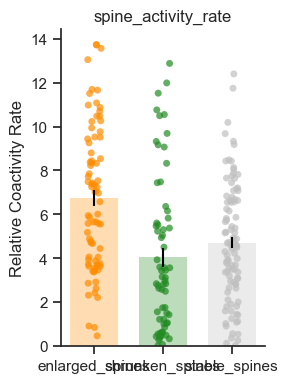

In [9]:
# Group mean activity plots
plot_data.plot_group_scatter_plot(
    variable_name="spine_activity_rate",
    group_type="plastic_spines",
    mean_type="mean",
    err_type="sem",
    figsize=(3,4),
    ytitle="Relative Coactivity Rate",
    ylim=None,
    s_colors=["darkorange", "forestgreen", "silver"],
    s_size=5,
    s_alpha=0.7,
    b_colors=["darkorange", "forestgreen", "silver"],
    b_edgecolors = "black",
    b_err_colors="black",
    b_width=0.7,
    b_linewidth=0,
    b_alpha=0.3,
    test_type="nonparametric",
    test_method="holm-sidak",
    save=False,
    save_path=figure_path,
)

╒══════════════════════════════════════╤═════════════╤══════╤═════════════╤═══════════════╕
│                                      │      sum_sq │   df │           F │        PR(>F) │
╞══════════════════════════════════════╪═════════════╪══════╪═════════════╪═══════════════╡
│ C(movement_spines)                   │   12.5851   │    1 │   1.29066   │   0.257074    │
├──────────────────────────────────────┼─────────────┼──────┼─────────────┼───────────────┤
│ C(plastic_spines)                    │  293.274    │    2 │  15.0384    │   7.10063e-07 │
├──────────────────────────────────────┼─────────────┼──────┼─────────────┼───────────────┤
│ C(movement_spines):C(plastic_spines) │    0.430343 │    2 │   0.0220669 │   0.978177    │
├──────────────────────────────────────┼─────────────┼──────┼─────────────┼───────────────┤
│ Residual                             │ 2310.95     │  237 │ nan         │ nan           │
╘══════════════════════════════════════╧═════════════╧══════╧═════════════╧═════

C:\Users\Jake\Documents\Anaconda3\envs\analysis_env\lib\site-packages\numpy\lib\nanfunctions.py:96: UserWarning: Warning: converting a masked element to nan.
  a = np.asanyarray(a)


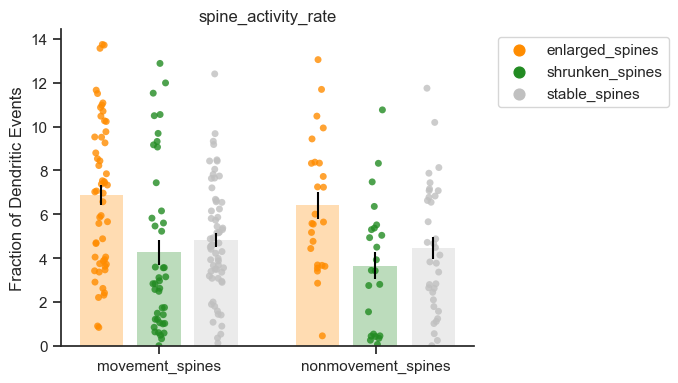

In [15]:

plot_data.plot_multi_group_scatter_plots(
    variable_name="spine_activity_rate",
    group_type="movement_spines",
    subgroup_type="plastic_spines",
    mean_type="mean",
    err_type="sem",
    figsize=(7,4),
    ytitle="Fraction of Dendritic Events",
    ylim=None,
    s_colors=["darkorange", "forestgreen", "silver"],
    s_alpha=0.8,
    s_size=5,
    b_colors=["darkorange", "forestgreen", "silver"],
    b_edgecolors="black",
    b_err_colors="black",
    b_width=0.2,
    b_linewidth=0,
    b_alpha=0.3,
    test_method="sidak",
    save=False,
    save_path=figure_path,
)

In [ ]:
plot_data.plot_group_spine_mean_traces(
    group_type="plastic_spines",
    trace_type="conj_dend_coactive_traces",
    exclude=[],
    avlines=(0,50,80),
    figsize=(5,5),
    colors=["darkorange", "forestgreen", "silver"], 
    ylim=None,
    save=False,
    save_path=figure_path
)

In [ ]:
plot_data.plot_spine_coactivity_distance(
    variable_name="movement_distance_coactivity_rate",
    group_type="plastic_spines",
    figsize=(5,5),
    colors=["darkorange", "forestgreen", "silver"],
    ylim=None,
    ytitle="Local Normalized Coactivity Rate",
    save=False,
    save_path=figure_path,
)

In [ ]:
plot_data.plot_histogram(
    variable="conj_relative_onset",
    bins=50,
    max_lim=None,
    avlines=(0,0),
    figsize=(5,5),
    color="blue",
    alpha=0.4,
    save=False,
    save_path=figure_path
)

In [ ]:
plot_data.plot_group_mean_heatmaps(
    trace_type="movement_spine_traces",
    group_type="movement_spines",
    figsize=(10,5),
    hmap_range=(0,1),
    center=None,
    sorted="peak",
    normalize=True,
    cmap="plasma",
    save=False,
    save_path=figure_path
)

In [ ]:
from Lab_Analyses.Spine_Analysis.spine_plotting import plot_sns_scatter_correlation




In [ ]:
original = np.log10(a.relative_volumes)
original = a.relative_volumes
norm = b.relative_volumes

In [ ]:
plot_sns_scatter_correlation(
    original,
    norm,
    CI=95,
    title="Relative Volume Comparison",
    xtitle="Original Relative Volume",
    ytitle="Normalized Relative Volume",
    marker_size=4,
    
)

In [ ]:
a = np.float64(5)

In [ ]:
if np.issubdtype(type(a), float):
    print("integer")

In [ ]:
a = 2
b = 6

diff = (b - a) / np.absolute(a)
diff

In [ ]:
on = np.nonzero(b == 1)[0]
off = np.nonzero(b == -1)[0]

In [ ]:
print(on)
print(off)

In [ ]:
if on[0] > off[0]:
    off = off[1:]
if len(on) > len(off):
    on = on[:-1]

In [ ]:
c = np.array([[1,2,0,4],
              [1,2,0,4]])

In [ ]:
d=np.sum(c, axis=0)

In [ ]:
import itertools
b = ["enlarged", "shrunken", "stable"]
list(itertools.combinations(b, 2))

In [ ]:
l = [a, b]
combinations = [p for p in itertools.product(*l)]

In [ ]:
combos = list(itertools.combinations(combinations, 2))
combos

In [ ]:
a = np.array([[1.000000,0.550846,0.718451],
              [0.550846,1.000000,0.036633],
              [0.718451,0.036633,1.000000]])
a

In [ ]:
combinations = list(range(a.shape[0]))
combos = list(itertools.combinations(combinations, 2))
combos

In [ ]:
pvals = [a[c[0],c[1]] for c in combos]
pvals

In [11]:
import pandas as pd
df = pd.DataFrame({"A": [1, 2], "B": [3.0, 4.5]})

In [12]:
d = {"a":[1,1,1], "b": [2,2,2]}

In [13]:
dataframe = pd.DataFrame({'Cars': np.repeat([1, 2, 3, 4, 5], 4),
                          'Oil': np.tile([1, 2, 3, 4], 5),
                          'Mileage': [36, 38, 30, 29,
                                      34, 38, 30, 29,
                                      34, 28, 38, 32,
                                      38, 34, 20, 44,
                                      26, 28, 34, 50]})

In [14]:
dataframe

,Cars,Oil,Mileage
0,1,1,36
1,1,2,38
2,1,3,30
3,1,4,29
4,2,1,34
5,2,2,38
6,2,3,30
7,2,4,29
8,3,1,34
9,3,2,28
